In [1]:
import numpy as np
import pandas as pd
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

# Set up plotting and warnings
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [2]:
# New data path with folders by emotion
data_path = "dataset"

# Step 1: Traverse the new directory structure to create the DataFrame
records = []
for emotion_folder in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion_folder)
    if os.path.isdir(emotion_path):
        for filename in os.listdir(emotion_path):
            # if filename.endswith('.mp3',',wav'):
                # Full path to the file
                file_path = os.path.join(emotion_path, filename)
                
                # Add metadata to records
                records.append([filename, file_path, emotion_folder])

# Create a DataFrame from the collected records
data = pd.DataFrame(records, columns=['filename', 'path', 'emotion'])
data

,filename,path,emotion
0,Adele - Someone Like You (Official Music Video...,dataset\Depressive\Adele - Someone Like You (O...,Depressive
1,All Too Well _ Taylor Swift (Lyrics).mp3,dataset\Depressive\All Too Well _ Taylor Swift...,Depressive
2,Billie Eilish - Lost Cause (Clean - Lyrics).mp3,dataset\Depressive\Billie Eilish - Lost Cause ...,Depressive
3,Brad Paisley - Whiskey Lullaby (Full Version -...,dataset\Depressive\Brad Paisley - Whiskey Lull...,Depressive
4,Breathe Me - Sia (Lyrics) .mp3,dataset\Depressive\Breathe Me - Sia (Lyrics) .mp3,Depressive
...,...,...,...
84,Katrina & The Waves - Walking On Sunshine (Off...,dataset\Surprised\Katrina & The Waves - Walkin...,Surprised
85,Mark Ronson - Uptown Funk (Lyrics) ft. Bruno M...,dataset\Surprised\Mark Ronson - Uptown Funk (L...,Surprised
86,One Direction - 18 (Lyrics).mp3,dataset\Surprised\One Direction - 18 (Lyrics).mp3,Surprised
87,Taylor Swift - You Belong With Me (Lyrics).mp3,dataset\Surprised\Taylor Swift - You Belong Wi...,Surprised


In [3]:
data['emotion'].value_counts()

Depressive    13
Happy         12
Manic         12
Neutral       12
Fear          10
Sad           10
Shocked       10
Surprised     10
Name: emotion, dtype: int64

In [4]:
# Define the feature extraction function
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

def feature_extraction(df, mfcc=True):
    features = []
    for _, record in tqdm(df.iterrows(), total=df.shape[0]):
        x, sr = librosa.load(record['path'])
        if mfcc:
            feature = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128), axis=1)
        else:
            feature = np.mean(librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128), axis=1)
        features.append(feature)
    
    dataf = pd.DataFrame(features)
    dataf['emotion'] = df['emotion'].values
    return dataf

In [5]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [6]:
# Extract MFCC features
dataf = feature_extraction(data)
X1 = dataf.iloc[:, :-1].values
y1 = dataf.iloc[:, -1].values
y1 = encoder.fit_transform(y1)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [03:34<00:00,  2.41s/it]


In [7]:
dataf

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,emotion
0,-154.618744,117.608582,-4.235273,3.793875,6.141376,-4.492969,-9.404162,-1.472228,-9.127667,0.055068,...,-1.589216,0.464056,1.381349,0.926673,0.143257,0.088769,-0.457100,-0.134559,-0.347735,Depressive
1,-100.011162,92.506287,5.733166,33.444847,10.108792,5.005388,9.191067,3.939583,3.205959,-0.126909,...,-1.805378,0.942661,0.250331,0.238767,0.660930,0.444777,-0.049910,0.238366,0.213405,Depressive
2,-185.161713,116.117523,16.386122,23.089396,0.496519,9.655194,4.870284,-5.321835,7.539968,3.915584,...,-0.095327,0.298621,-0.098003,0.064624,-0.129088,-0.124691,0.024079,-0.234712,-0.157335,Depressive
3,-232.096313,117.367401,17.756172,23.428665,10.138476,4.050837,1.419053,-1.775520,-2.885036,0.568988,...,-0.637102,0.633860,0.694861,0.262276,0.211878,0.135905,0.075738,0.285253,0.131718,Depressive
4,-203.378387,124.331749,-1.035766,10.196447,7.415482,-1.096666,7.686152,-2.752416,5.144033,1.319422,...,-0.821125,0.971539,0.341296,-0.297544,0.595126,0.554921,-0.014057,0.017214,0.318969,Depressive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,-160.318634,80.529510,-14.677757,25.925671,-0.194097,7.982927,0.531340,2.584473,-4.425087,1.830418,...,-0.074785,0.966487,-0.338778,-0.145487,-0.327540,-0.252508,-0.344580,-0.224603,0.274993,Surprised
85,-91.288361,66.727310,-5.597840,19.997404,1.912438,15.276937,1.521060,6.803944,0.961462,4.796917,...,0.145281,-0.066943,-0.070581,0.026245,0.081716,-0.055734,-0.051967,0.131905,-0.178238,Surprised
86,-116.405991,94.853027,19.860739,22.550890,13.127275,9.932749,0.191892,8.406134,-2.070602,2.958342,...,-1.015189,0.983261,1.205783,1.031647,0.639708,0.207238,0.171623,-0.009944,0.532407,Surprised
87,-36.075146,72.941574,12.616161,22.507656,10.158100,6.199883,9.293790,3.271612,2.863522,4.383554,...,-0.578761,0.950647,0.415475,-0.617029,-0.823396,-0.348196,-0.148543,-0.010686,-0.225825,Surprised


In [8]:
# Extract Mel-spectrogram features
dataf = feature_extraction(data, mfcc=False)
X2 = dataf.iloc[:, :-1].values
y2 = dataf.iloc[:, -1].values
y2 = encoder.fit_transform(y2)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [03:24<00:00,  2.30s/it]


In [9]:
dataf

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,emotion
0,0.056945,0.720419,8.367303,12.159625,6.209164,6.611029,10.461976,31.207733,50.894249,53.305946,...,0.052411,0.049255,0.039925,0.029916,0.036444,0.042683,0.031608,0.012937,0.000655,Depressive
1,14.850909,116.646622,183.758865,208.818741,109.098717,48.999828,63.389496,45.644623,31.426008,70.039848,...,0.095746,0.088325,0.081869,0.075060,0.069774,0.072948,0.074911,0.039238,0.003211,Depressive
2,85.903358,414.204407,293.934418,235.490524,166.736374,117.855606,85.622253,24.997993,51.578041,49.525803,...,0.018363,0.015285,0.016380,0.014146,0.012184,0.011412,0.012210,0.004200,0.000441,Depressive
3,5.501530,20.863220,20.889374,11.969875,8.554942,9.202363,13.773228,14.498637,15.988738,13.923204,...,0.011582,0.011065,0.008284,0.006912,0.006109,0.005585,0.005123,0.002699,0.000206,Depressive
4,9.027804,42.870060,36.594315,54.005264,37.085957,27.743593,23.746954,14.862354,16.296789,27.626537,...,0.007093,0.006857,0.007711,0.010520,0.008805,0.009322,0.010086,0.006401,0.000611,Depressive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.058974,0.973189,3.216947,4.702203,4.836564,9.058331,9.782578,3.791253,3.846510,2.199378,...,0.004437,0.004907,0.006216,0.005187,0.005643,0.004638,0.003188,0.001490,0.000137,Surprised
85,19.541641,144.455856,254.846344,120.556915,53.418316,36.547981,23.863398,10.841632,8.979728,7.592255,...,0.070976,0.064617,0.067538,0.062371,0.051730,0.050912,0.039329,0.024846,0.002478,Surprised
86,27.130489,115.598701,236.055710,185.223907,64.830338,68.232704,42.605293,71.407654,71.194939,39.092010,...,0.120808,0.118244,0.121417,0.122099,0.115671,0.118000,0.114231,0.060893,0.005140,Surprised
87,58.824749,226.727539,225.801910,156.501831,71.776566,31.038019,36.414410,55.026310,48.095642,36.303360,...,0.329899,0.377750,0.406674,0.404882,0.400350,0.375568,0.293545,0.139685,0.009411,Surprised


In [10]:
# Define Logistic Regression pipeline function
def LogisticRegressionPipeline(X, y, emotion_labels):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    pipeline = Pipeline([('scaler', StandardScaler()), ('LogisticRegression', LogisticRegression())])
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)
    
    cmatrix = confusion_matrix(y_test, y_pred)
    
    print("Training Performance")
    print(classification_report(y_train, y_train_pred, target_names=emotion_labels))
    print("-----------------------------------------")
    print("Test Performance")
    print(classification_report(y_test, y_pred, target_names=emotion_labels))
    print("-----------------------------------------")
    
    cv_score = cross_val_score(pipeline, X, y, cv=5)
    print("5-Folds Scores: ", cv_score)
    print("-----------------------------------------")
    print("5-Folds Average Score: ", cv_score.mean())
    
    return cv_score, cmatrix

In [11]:
# Define emotion labels based on encoder classes
emotion_labels = encoder.classes_

Training Performance
              precision    recall  f1-score   support

  Depressive       1.00      1.00      1.00        10
        Fear       1.00      1.00      1.00         8
       Happy       1.00      1.00      1.00        10
       Manic       1.00      1.00      1.00         9
     Neutral       1.00      1.00      1.00        10
         Sad       1.00      1.00      1.00         8
     Shocked       1.00      1.00      1.00         8
   Surprised       1.00      1.00      1.00         8

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00      1.00        71

-----------------------------------------
Test Performance
              precision    recall  f1-score   support

  Depressive       0.67      0.67      0.67         3
        Fear       1.00      1.00      1.00         2
       Happy       0.00      0.00      0.00         2
       Manic       0.00      0.00      0.00         

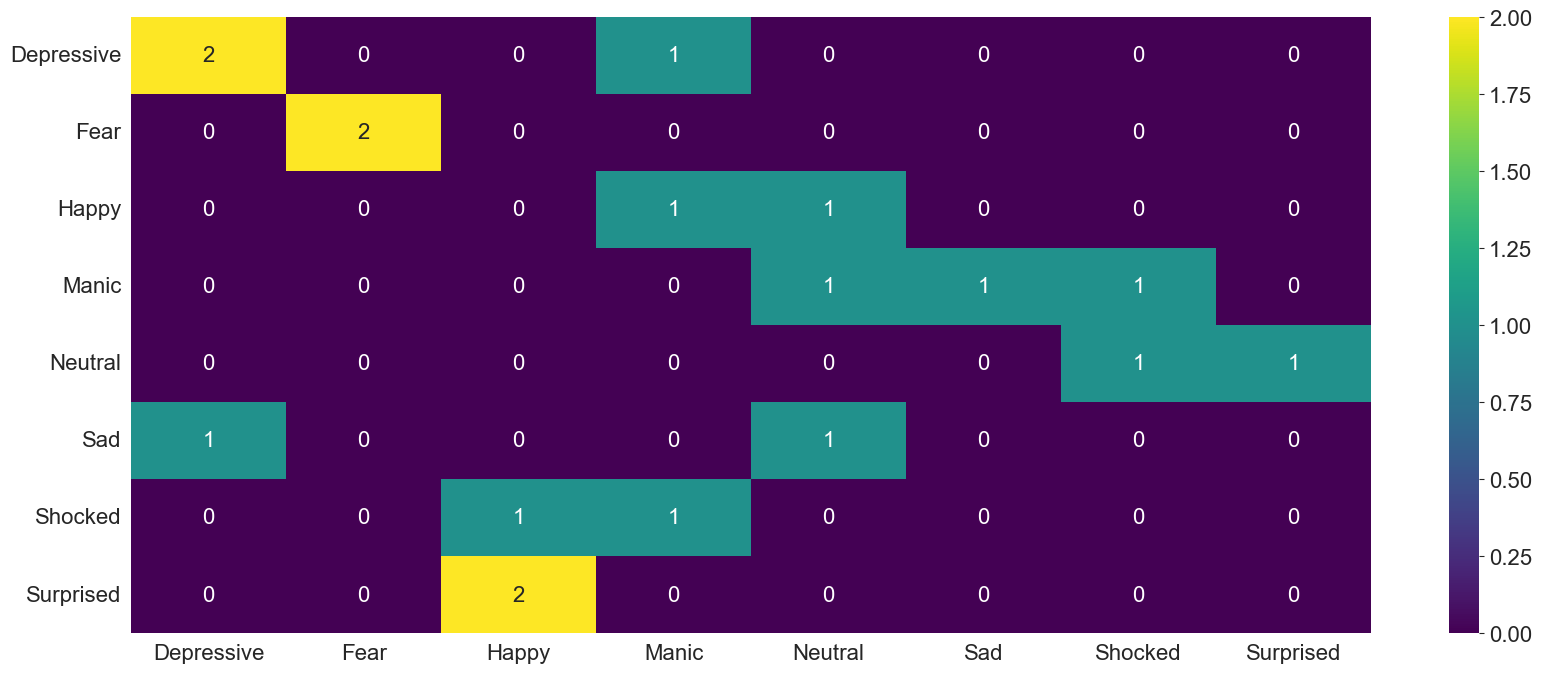

In [12]:
# Logistic Regression using MFCC features
scores, cmatrix = LogisticRegressionPipeline(X1, y1, emotion_labels)
sns.heatmap(cmatrix, annot=True, fmt='.3g', cmap='viridis', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.show()

Training Performance
              precision    recall  f1-score   support

  Depressive       1.00      1.00      1.00        10
        Fear       0.88      0.88      0.88         8
       Happy       0.90      0.90      0.90        10
       Manic       1.00      0.89      0.94         9
     Neutral       1.00      0.90      0.95        10
         Sad       1.00      0.88      0.93         8
     Shocked       0.64      0.88      0.74         8
   Surprised       0.88      0.88      0.88         8

    accuracy                           0.90        71
   macro avg       0.91      0.90      0.90        71
weighted avg       0.92      0.90      0.91        71

-----------------------------------------
Test Performance
              precision    recall  f1-score   support

  Depressive       0.25      0.67      0.36         3
        Fear       0.00      0.00      0.00         2
       Happy       0.00      0.00      0.00         2
       Manic       0.00      0.00      0.00         

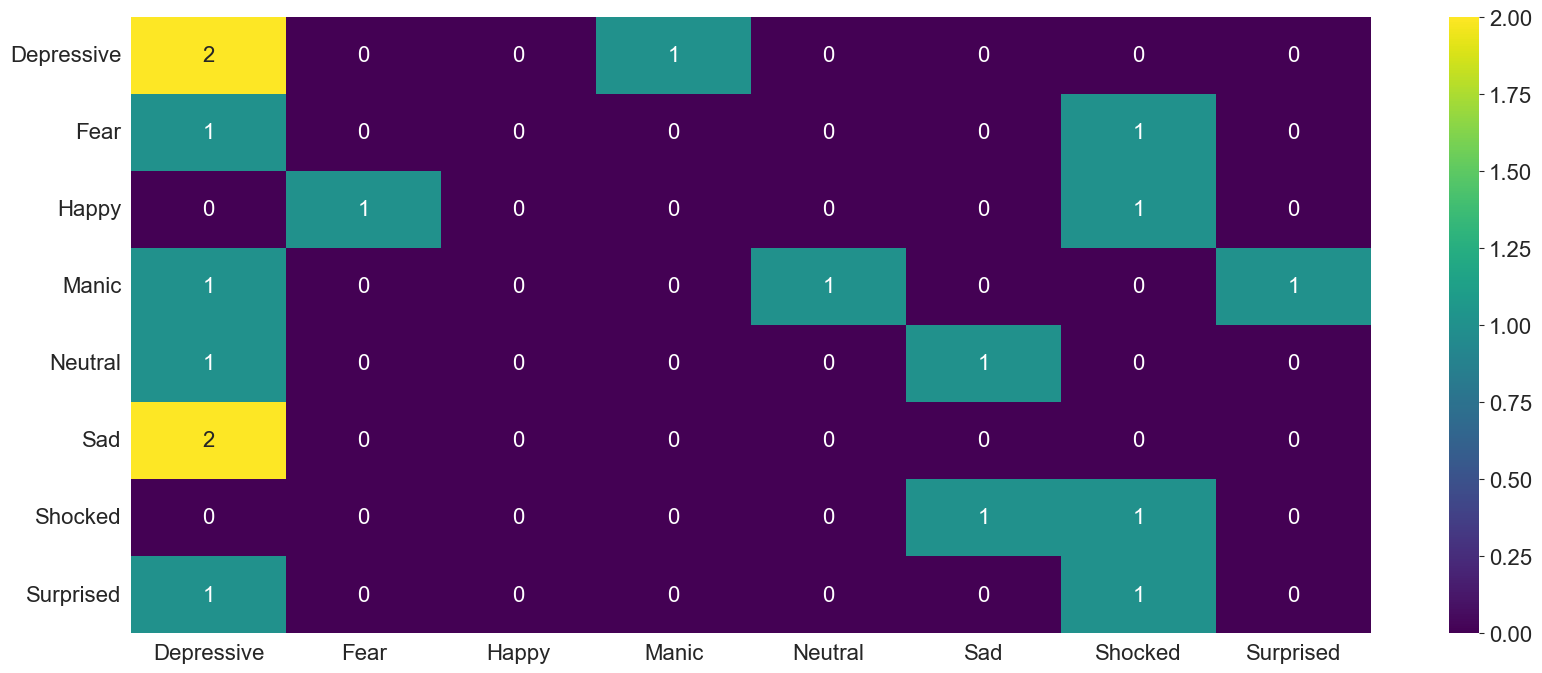

In [13]:
# Logistic Regression using Mel-spectrogram features
scores, cmatrix = LogisticRegressionPipeline(X2, y2, emotion_labels)
sns.heatmap(cmatrix, annot=True, fmt='.3g', cmap='viridis', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.show()

In [14]:
# Preparing the data for CNN models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, stratify=y1)
X_train = X_train.reshape(-1, 16, 8, 1)
X_test = X_test.reshape(-1, 16, 8, 1)

In [15]:
# Define CNN model
model = Sequential([
    InputLayer(input_shape=(16, 8, 1)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(2, 2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(emotion_labels), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 64)         640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 5

In [16]:
# Checkpoint and Early Stopping
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/100
3/3 [==============================] - 2s 232ms/step - loss: 3.3574 - accuracy: 0.1127 - val_loss: 2.5129 - val_accuracy: 0.2222

Epoch 00001: val_loss improved from inf to 2.51288, saving model to model.h5
Epoch 2/100
3/3 [==============================] - 0s 26ms/step - loss: 2.7102 - accuracy: 0.1972 - val_loss: 2.5555 - val_accuracy: 0.2222

Epoch 00002: val_loss did not improve from 2.51288
Epoch 3/100
3/3 [==============================] - 0s 25ms/step - loss: 2.4524 - accuracy: 0.2113 - val_loss: 2.3528 - val_accuracy: 0.0556

Epoch 00003: val_loss improved from 2.51288 to 2.35278, saving model to model.h5
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 2.1764 - accuracy: 0.2817 - val_loss: 1.9815 - val_accuracy: 0.1667

Epoch 00004: val_loss improved from 2.35278 to 1.98146, saving model to model.h5
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 1.9439 - accuracy: 0.2817 - val_loss: 1.8202 - val_accuracy: 0.3889

Epoc

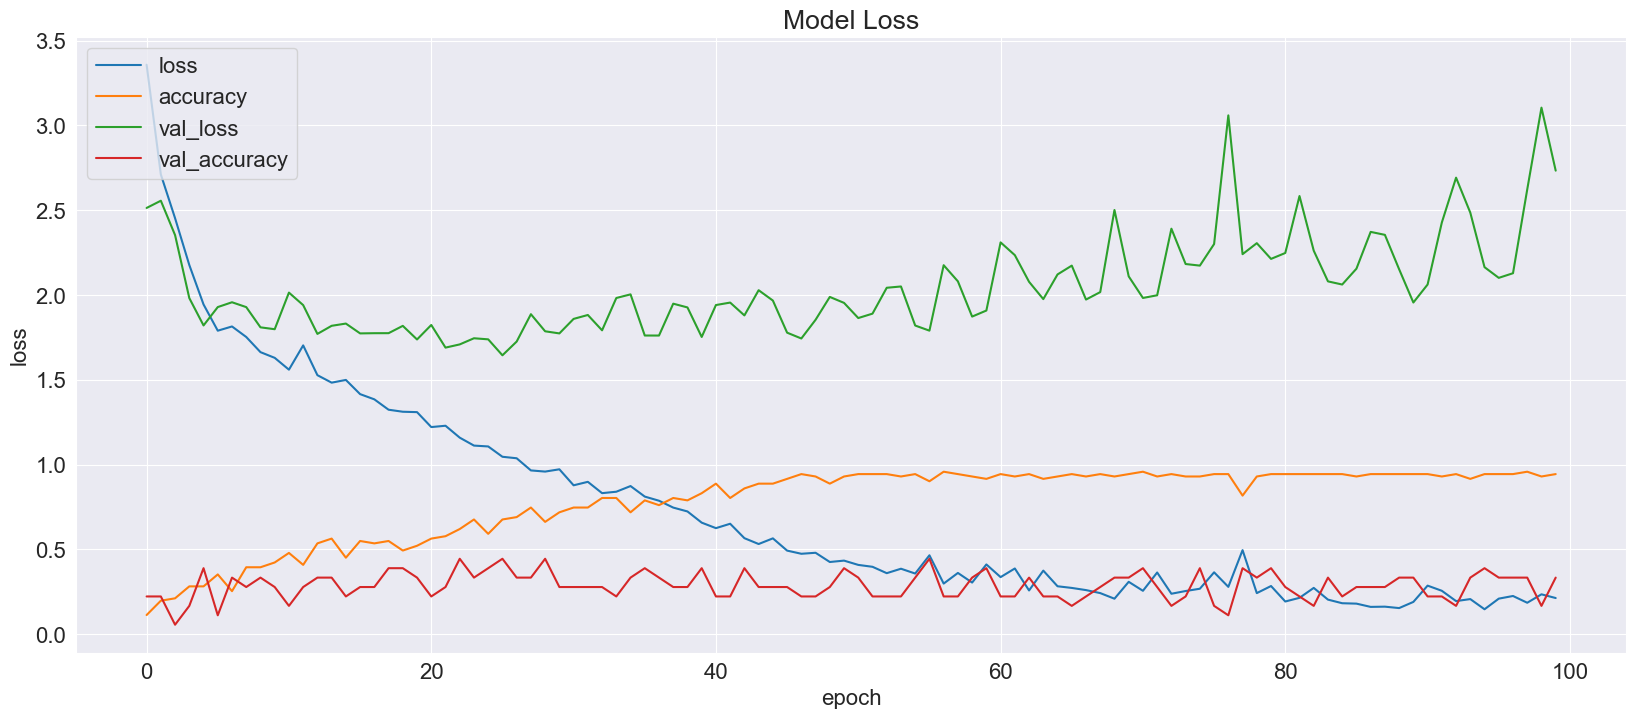

In [18]:
# Plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy'], loc='upper left')
plt.show()

In [19]:
# Make predictions and evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

              precision    recall  f1-score   support

  Depressive       0.50      0.67      0.57         3
        Fear       1.00      0.50      0.67         2
       Happy       0.00      0.00      0.00         2
       Manic       0.22      1.00      0.36         2
     Neutral       0.00      0.00      0.00         3
         Sad       0.00      0.00      0.00         2
     Shocked       0.50      0.50      0.50         2
   Surprised       0.00      0.00      0.00         2

    accuracy                           0.33        18
   macro avg       0.28      0.33      0.26        18
weighted avg       0.27      0.33      0.27        18



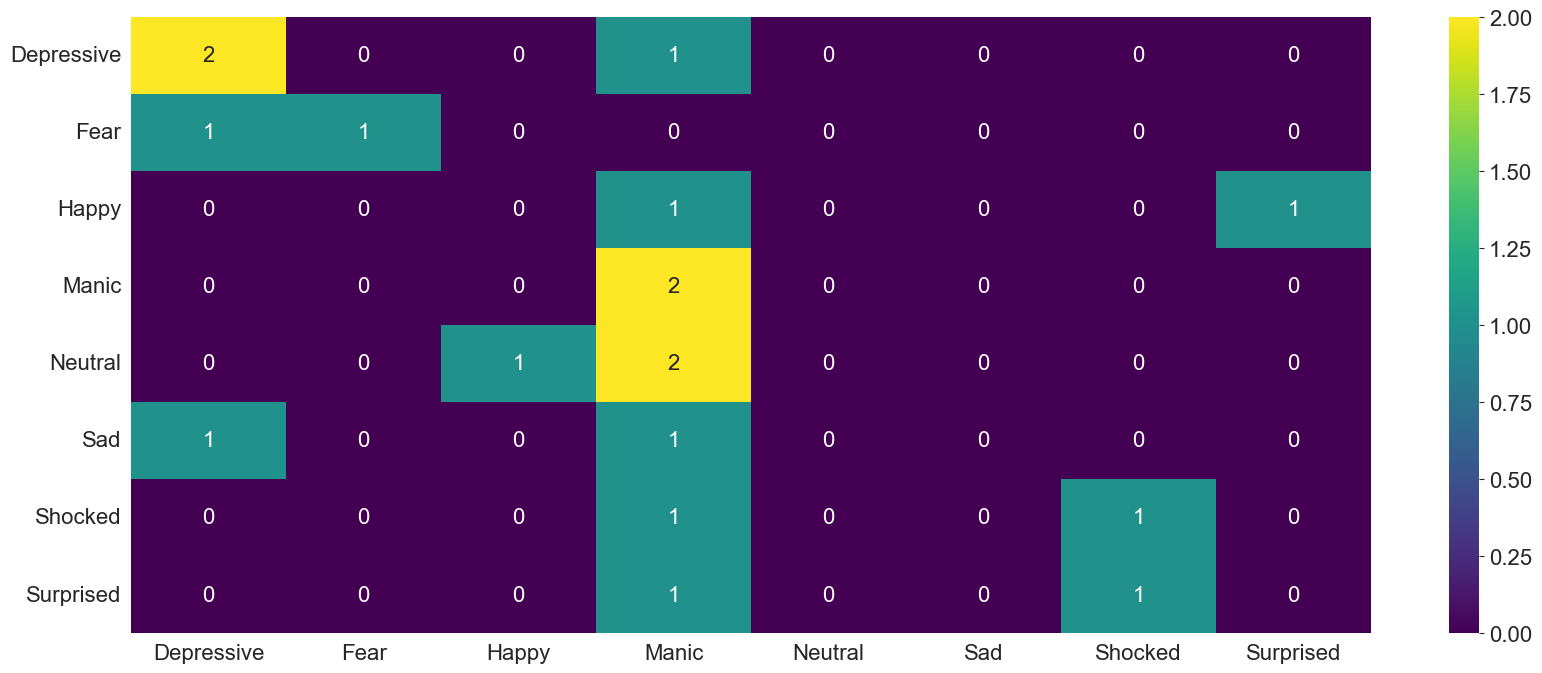

In [20]:
# Display classification report and confusion matrix
print(classification_report(y_test, y_pred_classes, target_names=emotion_labels))
cmatrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cmatrix, annot=True, fmt='.3g', cmap='viridis', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.show()